# ACA-Py & ACC-Py Verifier Template

## Copy this template into the root folder of your notebook workspace to get started

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
import os
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://rie-agent:3021 and an api key of adminApiKey


### Start a Webhook Server

In [3]:
webhook_port = int(os.getenv("WEBHOOK_PORT"))
webhook_host = "0.0.0.0"

await agent_controller.init_webhook_server(webhook_host, webhook_port)

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Register Agent Event Listeners

You can see some examples within the webhook_listeners recipe. Copy any relevant cells across and customise as needed.

In [4]:
listeners = []

# Receive connection messages
def connections_handler(payload):
    state = payload['state']
    connection_id = payload["connection_id"]
    their_role = payload["their_role"]
    routing_state = payload["routing_state"]
    
    print("----------------------------------------------------------")
    print("Connection Webhook Event Received")
    print("Connection ID : ", connection_id)
    print("State : ", state)
    print("Routing State : ", routing_state)
    print("Their Role : ", their_role)
    print("----------------------------------------------------------")

    if state == "invitation":
        # Your business logic
        print("invitation")
    elif state == "request":
        # Your business logic
        print("request")

    elif state == "response":
        # Your business logic
        print("response")
    elif state == "active":
        # Your business logic
        print(colored("Connection ID: {0} is now active.".format(connection_id), "green", attrs=["bold"]))



connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}


def verifier_proof_handler(payload):
    role = payload["role"]
    connection_id = payload["connection_id"]
    pres_ex_id = payload["presentation_exchange_id"]
    state = payload["state"]
    print("\n---------------------------------------------------------------------\n")
    print("Handle present-proof")
    print("Connection ID : ", connection_id)
    print("Presentation Exchange ID : ", pres_ex_id)
    print("Protocol State : ", state)
    print("Agent Role : ", role)
    print("Initiator : ", payload["initiator"])
    print("\n---------------------------------------------------------------------\n")
    

    if state == "request_sent":
        print("Presentation Request\n")
        print(payload["presentation_request"])
        print("\nThe presentation request is encoded in base64 and packaged into a DIDComm Message\n")
        print(payload["presentation_request_dict"])
        print("\nNote the type defines the protocol present-proof and the message request-presentation\n")
        print(payload["presentation_request_dict"]["@type"])
    elif state == "presentation_received":
        print("Presentation Received")
        print("We will not go into detail on this payload as it is comparable to the presentation_sent we looked at in the earlier cell.")
        print("This is the full payload\n")
        print(payload)
    else:
        print("Paload \n")
        print(payload)
        
verifier_listener = {
    "topic": "present_proof",
    "handler": verifier_proof_handler
}

listeners.append(verifier_listener)


listeners.append(connection_listener)

agent_controller.register_listeners(listeners)

## Define Presentation Request Object

It is possible to request a presentation of all this information in one go.

Whether this is advised is debateable

In [5]:
import time
# The GMC is the only entity able to issue GMC licences in the UK Healthcare system
gmc_schema_id = 'TDAbSf3Uqebg8N4XvybMbg:2:GMC Licence:0.0.1'

gmc_issuer_did = "TDAbSf3Uqebg8N4XvybMbg"

# cred_def_id = "<SOME CRED DEF>"

# Define the list of attributes and restrictions under which each attribute was issued that a prover must satisfy with a presentation
# NOTE: if identifying a schema or credential definition then the attribute name must be contained within the corresponding schema.
req_attrs = [
    {"name": "Headshot", 
     "restrictions": [{"schema_id": gmc_schema_id, "issuer_did": gmc_issuer_did}],
     "non_revoked": {"to": int(time.time() - 1)}
    },
    {"name": "Name", 
     "restrictions": [{"schema_id": gmc_schema_id, "issuer_did": gmc_issuer_did}],
     "non_revoked": {"to": int(time.time() - 1)}
    },
    {"name": "GMC Number", 
     "restrictions": [{"schema_id": gmc_schema_id, "issuer_did": gmc_issuer_did}],
     "non_revoked": {"to": int(time.time() - 1)}
    },
]

# We could extend this to request the name attribute aswell if we wanted.


gmc_licence_proof_request = {
    "name": "Proof of GMC Licence",
    "version": "1.0",
    "requested_attributes": {
        # They must follow this uuid pattern
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"{req_attr['name']}":
        req_attr for req_attr in req_attrs
    },
    # Predicates allow us to specify range proofs or set membership on attributes. For example greater than 10.
    # We will ignore these for now.
    "requested_predicates": {
#         f"0_{req_pred['name']}_GE_uuid":
#         req_pred for req_pred in req_preds
    },
    # You can also request the entire proof request be non-revoked
#     "non_revoked":  {"to": int(time.time())}
}

## Create Invitation

Note the current arguments specified are in their default configurations. 

In [6]:
# Alias for invited connection
alias = None
auto_accept = False
# Use public DID?
public = "false"
# Should this invitation be usable by multiple invitees?
multi_use = "false"

invitation_response = await agent_controller.connections.create_invitation(alias, auto_accept, public, multi_use)
# Is equivalent to above. Arguments are optionally
# invitation_response = await agent_controller.connections.create_invitation()



# You probably want to keep this somewhere so you can enage in other protocols with this connection.
connection_id = invitation_response["connection_id"]


----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  89527fac-f245-407b-98bc-9e4010e96acc
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
invitation


## Share Invitation Object with External Agent

Typically in this jupyter notebook playground that involves copying it across to another agent's business logic notebook where they are the invitee. (see prover_template)

In [7]:
invitation = invitation_response["invitation"]
## Copy this output
print(invitation)

{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': 'b9544cb3-52ab-40e7-9ff3-81f4fdd922f4', 'label': 'Royal Infirmary Edinburgh', 'recipientKeys': ['31ypNHG4hiwcQS6aHWxvgQA89HFRVSyJSNzezsq2xo5x'], 'serviceEndpoint': 'https://323b6508202c.ngrok.io'}


## Display Invite as QR Code

This is useful if you wish to establish a connection with a mobile wallet.

In [8]:
import qrcode
# Link for connection invitation
invitation_url = invitation_response["invitation_url"]
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=5,
        border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img

ModuleNotFoundError: No module named 'qrcode'

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  89527fac-f245-407b-98bc-9e4010e96acc
State :  request
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
request
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  89527fac-f245-407b-98bc-9e4010e96acc
State :  response
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
response
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  89527fac-f245-407b-98bc-9e4010e96acc
State :  active
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
Connection ID: 89527fac-f245-407b-98bc-9e4010e96acc is now active.


## Send Proof Request

This identifies a connection and a proof request object (you will need to update the variable name enclosed with <>) 

In [9]:
proof_request = {
    "comment": "Please prove you have a GMC Licence",
    "connection_id": connection_id,
    "proof_request": gmc_licence_proof_request,
    # Do you want your agent to trace this request (for debugging)
    "trace": True
}

proof_request_response = await agent_controller.proofs.send_request(proof_request)


---------------------------------------------------------------------

Handle present-proof
Connection ID :  89527fac-f245-407b-98bc-9e4010e96acc
Presentation Exchange ID :  33e2b79f-8a6a-46e5-bbcc-8fa998411392
Protocol State :  request_sent
Agent Role :  verifier
Initiator :  self

---------------------------------------------------------------------

Presentation Request

{'name': 'Proof of GMC Licence', 'version': '1.0', 'requested_attributes': {'Headshot': {'name': 'Headshot', 'restrictions': [{'schema_id': 'TDAbSf3Uqebg8N4XvybMbg:2:GMC Licence:0.0.1', 'issuer_did': 'TDAbSf3Uqebg8N4XvybMbg'}], 'non_revoked': {'to': 1621612888}}, 'Name': {'name': 'Name', 'restrictions': [{'schema_id': 'TDAbSf3Uqebg8N4XvybMbg:2:GMC Licence:0.0.1', 'issuer_did': 'TDAbSf3Uqebg8N4XvybMbg'}], 'non_revoked': {'to': 1621612888}}, 'GMC Number': {'name': 'GMC Number', 'restrictions': [{'schema_id': 'TDAbSf3Uqebg8N4XvybMbg:2:GMC Licence:0.0.1', 'issuer_did': 'TDAbSf3Uqebg8N4XvybMbg'}], 'non_revoked': {'to': 

## Get Presentation Exchange Record

This record keeps track of the current state of the presentation protocol, which must be in the `presentation_received` state before the presentation can be verified.

Note: This could also happen in the webhook logic.

In [11]:
presentation_exchange_id = proof_request_response["presentation_exchange_id"]

pres_record = await agent_controller.proofs.get_record_by_id(presentation_exchange_id)

# print(pres_record)

## Verify Presentation

Only if it is in the right state. 

Note: Verifying a presentation moves the state to `verified` regardless of whether the presentation request has been satisfied. To check this you must refer to the `verified` property on the response.

In [ ]:
verified_response = await agent_controller.proofs.verify_presentation(presentation_exchange_id)

verified = verified_response["verified"]

## Parsing Disclosed Attribute Values from Presentation

A presentation object contains three classes of attributes. 
* Revealed Attributes: Attributes that were signed by an issuer and have been revealed in the presentation process
* Self Attested Attributes: Attributes that the prover has self attested to in the presentation object.
* Predicate proofs: Attribute values that have been proven to meet some statement. (TODO: Show how you can parse this information)

### Parse Revealed Attributes

In [13]:
import base64
if verified == "true":
    for (name, val) in verified_response['presentation']['requested_proof']['revealed_attrs'].items():
        ## This is the actual data that you want. It's a little hidden
    #     print("Attribute : ", val)
        print(f"Attribute Name {name} Raw Value : {val['raw']}")

        if name == "Headshot":
            try:
                f = open("headshot.jpg", "wb+")
                base64_img_str = val['raw']
                b64_encoded = base64_img_str.encode('utf-8')
                decoded_img_data = base64.decodebytes(b64_encoded)
                f.write(decoded_img_data)
                f.close()
    #             base64_img_bytes = attribute["value"].encode('utf-8')
    #             decoded_img_data = base64.decodebytes(base64_img_bytes)

            except Exception as e:
                print("Error writing file", e)

Attribute Name Name Raw Value : Will A
Attribute Name GMC Number Raw Value : 1231231
Attribute Name Headshot Raw Value : /9j/4AAQSkZJRgABAQAAAQABAAD/4QQwRXhpZgAASUkqAAgAAAAOAAABAwABAAAAQBMAAAEBAwABAAAA0AwAAAIBAwADAAAAtgAAAA4BAgCLAAAAvAAAAA8BAgASAAAASAEAABABAgAJAAAAWgEAABIBAwABAAAAAQAAABUBAwABAAAAAwAAABoBBQABAAAAZAEAABsBBQABAAAAbAEAACgBAwABAAAAAgAAADEBAgAQAAAAdAEAAJiCAgAdAAAAhAEAAGmHBAABAAAAogEAAAAAAAAIAAgACAA1dGggSW50ZXJuYXRpb25hbCBDb25mZXJlbmNlIG9uIEJpZyBEYXRhIGluIEN5YmVyIFNlY3VyaXR5IGF0IEVkaW5idXJnaCBOYXBpZXIgVW5pdmVyc2l0eSwgNCAmIDUgSnVuZSAyMDE5LiAgV2VkIDUgSnVuZSBhZnRlcm5vb24gc2Vzc2lvbi4AAE5JS09OIENPUlBPUkFUSU9OAE5JS09OIEQ0AAAsAQAAAQAAACwBAAABAAAAU2hvdHdlbGwgMC4yOC40AEVkaW5idXJnaCBOYXBpZXIgVW5pdmVyc2l0eS4AACkAmoIFAAEAAACUAwAAnYIFAAEAAACcAwAAIogDAAEAAAABAAAAJ4gDAAEAAADECQAAMIgDAAEAAAACAAAAAJAHAAQAAAAwMjIxAZIKAAEAAACkAwAAApIFAAEAAACsAwAABJIKAAEAAAC0AwAABZIFAAEAAAC8AwAAB5IDAAEAAAAFAAAACJIDAAEAAAADAAAACZIDAAEAAAAAAAAACpIFAAEAAADEAwAAkJICAAMAAAA4MAAAkZICAAMAAAA4MAAAkpICAAMAAAAxMAAAAaADAAE

### In particular the Hositlal Admin Staff can Verify the Photograph matches the Doctor in Front of them

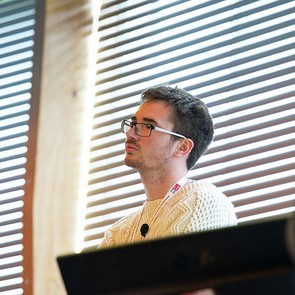

In [14]:
from IPython.display import Image
Image("headshot.jpg")

## Your Own Business Logic

Now you should have an established, active connection you can write any custom logic you want to engage with protocols with the connection

In [ ]:
## Custom Logic

## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [16]:
await agent_controller.terminate()